# Hospitality Employees

https://www.kaggle.com/datasets/gabrielsantello/hospitality-employees-time-series-dataset?select=HospitalityEmployees.csv

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from pandas import to_datetime
from statsmodels.tsa.stattools import adfuller
from pmdarima.arima import nsdiffs
from statsmodels.tsa.seasonal import seasonal_decompose, STL
import pmdarima as pm
from itertools import product
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.stats.stattools import durbin_watson

In [3]:
import warnings
warnings.filterwarnings("ignore")
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)
from statsmodels.tools.sm_exceptions import ValueWarning
warnings.simplefilter('ignore', ValueWarning)

## Dataset

In [4]:
raw = pd.read_csv('data/HospitalityEmployees.csv')

raw

,Date,Employees
0,1/1/1990,1064.5
1,2/1/1990,1074.5
2,3/1/1990,1090.0
3,4/1/1990,1097.4
4,5/1/1990,1108.7
...,...,...
343,8/1/2018,2019.1
344,9/1/2018,1992.5
345,10/1/2018,1984.3
346,11/1/2018,1990.1


In [5]:
# Convert 'datetime' to datetime type
raw['Date'] = pd.to_datetime(raw['Date'])

# Set as datetime index
raw.set_index('Date', inplace=True)                  

# Display
raw.head()

,Employees
Date,
1990-01-01,1064.5
1990-02-01,1074.5
1990-03-01,1090.0
1990-04-01,1097.4
1990-05-01,1108.7


In [6]:
raw.tail()

,Employees
Date,
2018-08-01,2019.1
2018-09-01,1992.5
2018-10-01,1984.3
2018-11-01,1990.1
2018-12-01,2000.2


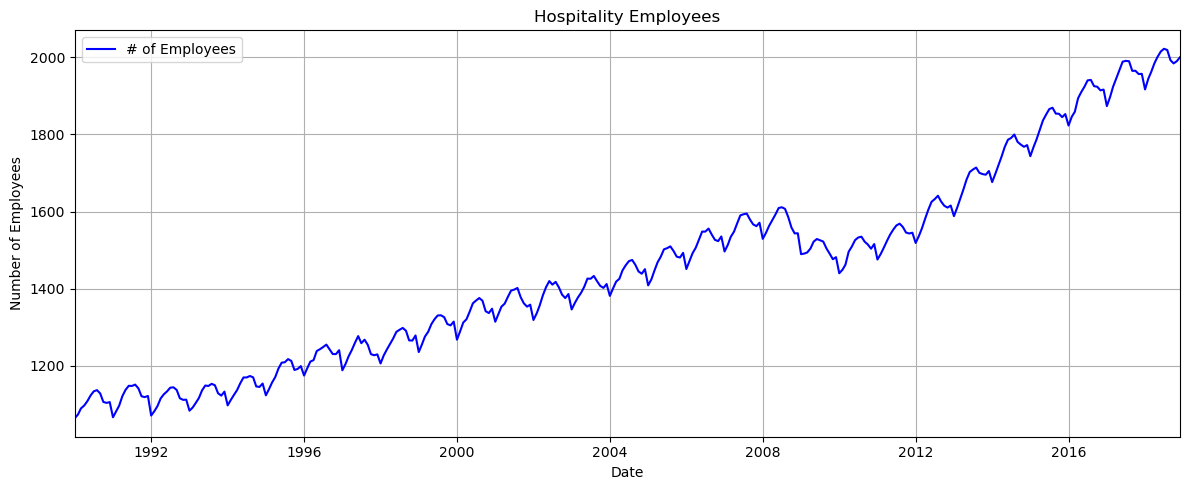

In [7]:
# Plot actual and fitted serie
plt.figure(figsize=(12, 5))                                      

plt.plot(raw.index, raw['Employees'], label='# of Employees', color='blue')     

plt.title('Hospitality Employees')                      
plt.xlabel('Date')                                        
plt.ylabel('Number of Employees')  
plt.xlim(pd.to_datetime('1990-01-01'), pd.to_datetime('2018-12-01'))
#plt.ticklabel_format(style='plain', axis='y')  # Disable scientific notation on y-axis
plt.grid(True)                                            
plt.legend(loc=2)                                             
plt.tight_layout()                                       
plt.show()

# SARIMA

### Split in Train & Test datasets

In [8]:
# Split the data
cutoff = pd.to_datetime("2016-01-01")

train = raw[raw.index < cutoff]
test = raw[raw.index >= cutoff]

# Show results
print("Train shape:", train.shape)
print("Test shape:", test.shape)
print()
print(train.tail())
print()
print(test.head())

Train shape: (312, 1)
Test shape: (36, 1)

            Employees
Date                 
2015-08-01     1869.3
2015-09-01     1854.2
2015-10-01     1853.7
2015-11-01     1845.0
2015-12-01     1852.9

            Employees
Date                 
2016-01-01     1823.2
2016-02-01     1846.1
2016-03-01     1858.9
2016-04-01     1893.9
2016-05-01     1909.8


In [9]:
emp_series = train['Employees']

len(emp_series)

312

### Find 'd'

In [10]:
def determine_nonseasonal_d(series, max_d=2, alpha=0.05):

    d = 0

    adf_result = adfuller(series)                # Run ADF test on the original series
    p_value = adf_result[1]
    print(f"d = {d} | ADF Statistic = {adf_result[0]:.4f}, p-value = {p_value:.4f}")

    if p_value < alpha:                          # If the original series is stationary
        
        return d
        
    else:
        while p_value > alpha and d < max_d:
            d += 1
            series = np.diff(series, n=1)        # Perform first-order differencing
            ad_fuller_result1 = adfuller(series)  
            p_value = ad_fuller_result1[1]
            print(f"d = {d} | ADF Statistic = {ad_fuller_result1[0]:.4f}, p-value = {p_value:.4f}")   
            
        return d  


d = determine_nonseasonal_d(emp_series)
print(f"\nNon-seasonal differencing term (d): {d}")

d = 0 | ADF Statistic = 0.4451, p-value = 0.9831
d = 1 | ADF Statistic = -2.4060, p-value = 0.1400
d = 2 | ADF Statistic = -4.6979, p-value = 0.0001

Non-seasonal differencing term (d): 2


### Find 'S'

In [11]:
def detect_seasonal(series):

    # Apply Fourier Transform
    fourier = np.fft.fft(series - np.mean(series))
    frequencies = np.fft.fftfreq(len(series))

    # Identify the most significant frequency (ignoring the 0 frequency)
    positive_freqs = frequencies[np.where(frequencies > 0)]
    significant_freq = positive_freqs[np.argmax(np.abs(fourier[1:len(positive_freqs)+1]))]

    # Calculate the seasonal period (S)
    S = int(1 / significant_freq)

    return print(f"Detected Seasonal Period: S = {S}")

detect_seasonal(emp_series)

Detected Seasonal Period: S = 312


### Check possible S's

In [12]:
def detect_top_seasonal_periods(series, top_n=5):

    # Remove mean to center the series
    series_detrended = series - np.mean(series)

    # Apply Fourier Transform
    fourier = np.fft.fft(series_detrended)
    frequencies = np.fft.fftfreq(len(series))

    # Only keep positive frequencies (exclude zero)
    positive_mask = frequencies > 0
    positive_freqs = frequencies[positive_mask]
    magnitudes = np.abs(fourier[positive_mask])

    # Get indices of top N magnitudes
    top_indices = np.argsort(magnitudes)[-top_n:][::-1]

    # Prepare result
    top_periods = [(round(1 / positive_freqs[i], 2), magnitudes[i]) for i in top_indices]

    # Display results
    print("Top Seasonal Periods (in time units):")
    for i, (period, magnitude) in enumerate(top_periods, 1):
        print(f"{i}. Period = {period} (Frequency = {round(positive_freqs[top_indices[i-1]], 5)}), Magnitude = {round(magnitude, 2)}")


detect_top_seasonal_periods(emp_series, top_n=10)

Top Seasonal Periods (in time units):
1. Period = 312.0 (Frequency = 0.00321), Magnitude = 33053.16
2. Period = 156.0 (Frequency = 0.00641), Magnitude = 15566.48
3. Period = 104.0 (Frequency = 0.00962), Magnitude = 14361.7
4. Period = 78.0 (Frequency = 0.01282), Magnitude = 12095.78
5. Period = 62.4 (Frequency = 0.01603), Magnitude = 6392.45
6. Period = 44.57 (Frequency = 0.02244), Magnitude = 6196.08
7. Period = 12.0 (Frequency = 0.08333), Magnitude = 5461.15
8. Period = 52.0 (Frequency = 0.01923), Magnitude = 5419.38
9. Period = 39.0 (Frequency = 0.02564), Magnitude = 5058.58
10. Period = 28.36 (Frequency = 0.03526), Magnitude = 3967.13


### Find 'D'

In [13]:
def determine_seasonal_D(series, m=12):
    
    # Get seasonal differencing terms using CH and OCSB tests
    D = max(nsdiffs(series, m=m, test='ch'),
            nsdiffs(series, m=m, test='ocsb'))

    return D

for m in  [12, 48]:

    D = determine_seasonal_D(emp_series, m)
    print(f'Seasonal differencing term (D) for {m}: {D}')

Seasonal differencing term (D) for 12: 0
Seasonal differencing term (D) for 48: 0


In [14]:
print('                Canova-Hansen test:', nsdiffs(emp_series, m=12, test='ch'))
print('Osborn-Chui-Smith-Birchenhall test:', nsdiffs(emp_series, m=12, test='ocsb'))

                Canova-Hansen test: 0
Osborn-Chui-Smith-Birchenhall test: 0


### Seasonal Decomposition

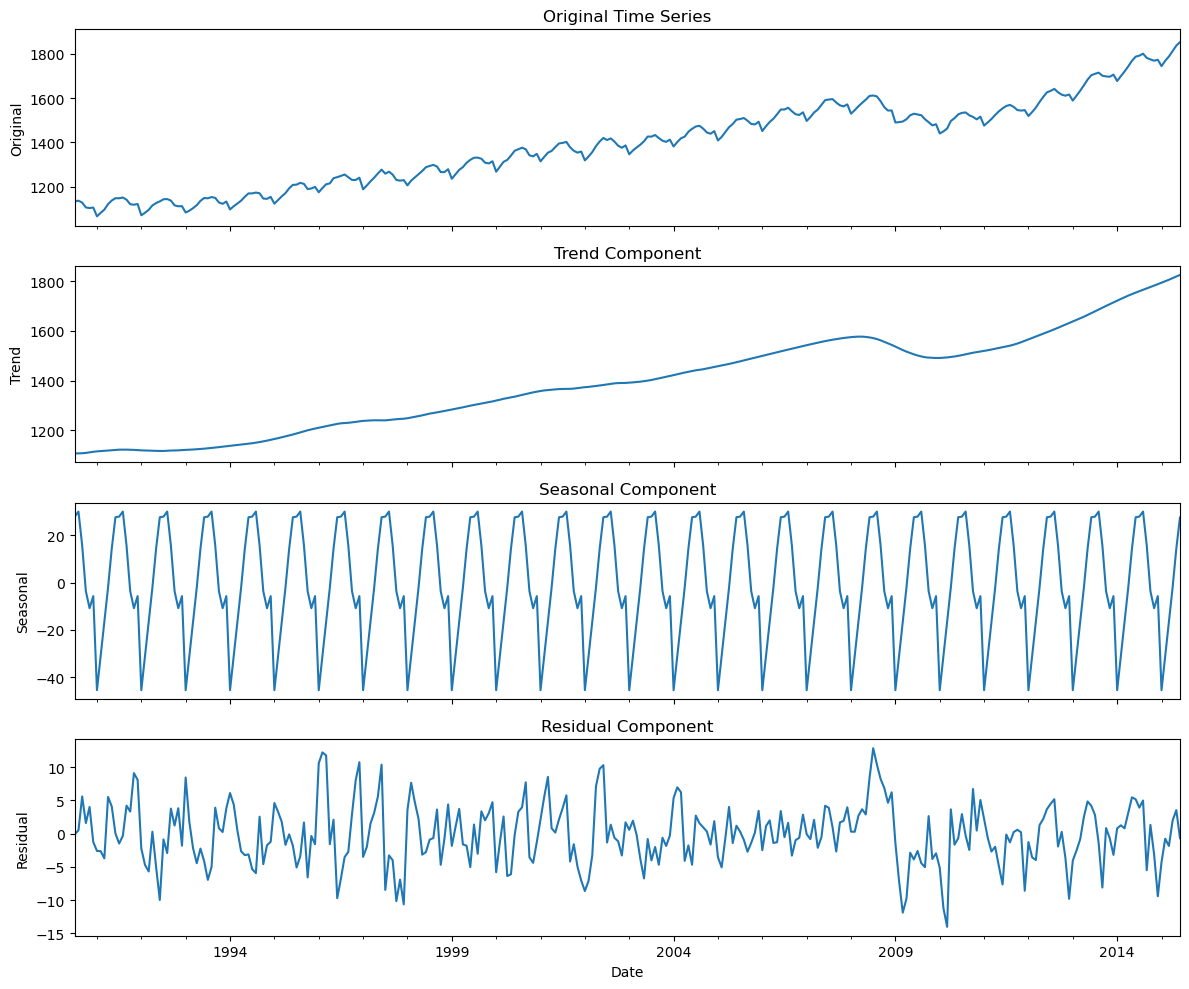

In [15]:
result = seasonal_decompose(emp_series, model='aditive', period=12)

trend = result.trend.dropna()
seasonal = result.seasonal.dropna()
residual = result.resid.dropna()


# Plot the decomposition
fig, axes = plt.subplots(4, 1, figsize=(12, 10), sharex=True)

result.observed.plot(ax=axes[0], title="Original Time Series")
axes[0].set_ylabel('Original')

trend.plot(ax=axes[1], title="Trend Component")
axes[1].set_ylabel('Trend')

seasonal.plot(ax=axes[2], title="Seasonal Component")
axes[2].set_ylabel('Seasonal')

residual.plot(ax=axes[3], title="Residual Component")
axes[3].set_ylabel('Residual')

plt.tight_layout()
plt.show()

### Model

In [16]:
def best_auto_arima(series, d=0, D=0, S=12):

    # Perform a full search over the same grid as your manual SARIMAX model
    auto_model = pm.auto_arima(
        series,                     # The time series data
        seasonal=True,              # Enable seasonal component
        m=S,                        # Seasonal period
        d=d,                        # Set differencing 
        D=D,                        # Set seasonal differencing
        start_p=0, max_p=3,         # p 
        start_q=0, max_q=3,         # q 
        start_P=0, max_P=3,         # P 
        start_Q=0, max_Q=3,         # Q 
        stepwise=False,             # Disable stepwise search (enable full grid search)
        trace=False,                # Print model search progress
        error_action='ignore',      # Ignore errors and continue
        suppress_warnings=True,     # Suppress convergence warnings
        information_criterion='aic' # Use AIC to choose the best model
    )

    # Print the best model found
    print(f"Best model: SARIMA{auto_model.order}{auto_model.seasonal_order}")

best_auto_arima(emp_series, d=2, D=0, S=12)

Best model: SARIMA(1, 2, 1)(1, 0, 1, 12)


In [17]:
def combinator(items, r=1):
    combo = [i for i in product(*items, repeat=r)]       # Generate Cartesian product of input lists
    return combo                                         # Return the list of combinations


def find_best(series, d=0, D=0, S=12):

    P_ns, Q_ns = [0, 1, 2, 3], [0, 1, 2, 3]              # Define search ranges for non-seasonal parameters (p, q)
    P_s, Q_s = [0, 1, 2, 3], [0, 1, 2, 3]                # Define search ranges for seasonal parameters (P, Q)


    total = len(P_ns) * len(Q_ns) * len(P_s) * len(Q_s)
    print(f'Total number of models: {total}')

    vals = combinator([P_ns, [d], Q_ns, P_s, [D], Q_s])  # Generate all combinations of SARIMA parameter sets

    score = {}                                           # Dictionary to store model evaluation metrics

    for i, (p, d, q, P, D, Q) in enumerate(vals):        # Iterate over all parameter combinations
    
        if i % 15 == 0:                                  # Print progress every 15 models
            print(f'Running model #{i} using SARIMA({p},{d},{q})({P},{D},{Q},{S})')

        m = SARIMAX(series,                              # Define SARIMA model with current parameter set
                    order=(p,d,q), 
                    seasonal_order=(P, D, Q, S),   
                    enforce_stationarity=False)          # Allow non-stationary models for broader search

        res = m.fit(disp=0, low_memory=True)             # Fit the model silently

        score[i] = {                                     # Store model results and evaluation metrics
            'non-seasonal order': (p, d, q),      
            'seasonal order': (P, D, Q),
            'AIC': res.aic,                              # Akaike Information Criterion
        }
        
    print("\nBest models by AIC:")
    best_models = pd.DataFrame(score).T.sort_values(by='AIC').reset_index().head()
    print(best_models)


find_best(series=emp_series, d=2, D=0, S=12)

Total number of models: 256
Running model #0 using SARIMA(0,2,0)(0,0,0,12)
Running model #15 using SARIMA(0,2,0)(3,0,3,12)
Running model #30 using SARIMA(0,2,1)(3,0,2,12)
Running model #45 using SARIMA(0,2,2)(3,0,1,12)
Running model #60 using SARIMA(0,2,3)(3,0,0,12)
Running model #75 using SARIMA(1,2,0)(2,0,3,12)
Running model #90 using SARIMA(1,2,1)(2,0,2,12)
Running model #105 using SARIMA(1,2,2)(2,0,1,12)
Running model #120 using SARIMA(1,2,3)(2,0,0,12)
Running model #135 using SARIMA(2,2,0)(1,0,3,12)
Running model #150 using SARIMA(2,2,1)(1,0,2,12)
Running model #165 using SARIMA(2,2,2)(1,0,1,12)
Running model #180 using SARIMA(2,2,3)(1,0,0,12)
Running model #195 using SARIMA(3,2,0)(0,0,3,12)
Running model #210 using SARIMA(3,2,1)(0,0,2,12)
Running model #225 using SARIMA(3,2,2)(0,0,1,12)
Running model #240 using SARIMA(3,2,3)(0,0,0,12)
Running model #255 using SARIMA(3,2,3)(3,0,3,12)

Best models by AIC:
   index non-seasonal order seasonal order          AIC
0     63          (0,

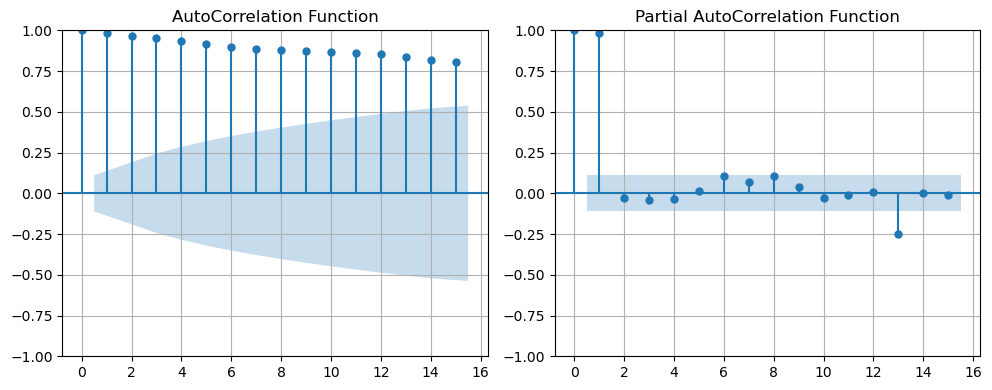

In [18]:
def acf_and_pacf(series, lagsn=15):

    # Create a 1x2 grid for subplots
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))  

    # Plot AutoCorrelation Function
    plot_acf(series, ax=axes[0], lags=lagsn)
    axes[0].set_title("AutoCorrelation Function", fontsize=12)
    axes[0].grid(True)

    # Plot Partial Autocorrelation Function
    plot_pacf(series, ax=axes[1], lags=lagsn)
    axes[1].set_title("Partial AutoCorrelation Function", fontsize=12)
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()


acf_and_pacf(emp_series, lagsn=15)

In [19]:
# Define the SARIMA (p,d,q)(P,D,Q,S) model
model_121 = SARIMAX(endog=train['Employees'],       # Time series data
                    order=(1, 2, 1),                # Non-seasonal order (p,d,q)
                    seasonal_order=(3, 0, 3, 12),   # Seasonal order (P,D,Q,S)
                    enforce_stationarity=False)     # Allow non-stationary behavior

# Fit the model
model_fit_121 = model_121.fit()

# Display summary of the model
print(model_fit_121.summary())

                                         SARIMAX Results                                          
Dep. Variable:                                  Employees   No. Observations:                  312
Model:             SARIMAX(1, 2, 1)x(3, 0, [1, 2, 3], 12)   Log Likelihood                -835.426
Date:                                    Mon, 26 May 2025   AIC                           1688.852
Time:                                            12:11:54   BIC                           1721.305
Sample:                                        01-01-1990   HQIC                          1701.881
                                             - 12-01-2015                                         
Covariance Type:                                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1953      0.076     -2.556      0

In [20]:
def test_parameters(model):

    # Identify irrelevant variables: exclude sigma2
    exo_vars = [name for name in model.params.index if name != 'sigma2']

    # Extract confidence intervals
    conf_int = model.conf_int()
    irrelevant_found = False  # Flag to track if any irrelevant variable is found

    # Loop through each parameter
    for var in exo_vars:
        lower, upper = conf_int.loc[var]
        p_val = model.pvalues[var]

        # If CI includes 0 and p-value > 0.05 → irrelevant
        if lower < 0 < upper and p_val > 0.05:
            coef = model.params[var]
            print(f"{var} coefficient: {coef:.4f}")
            print(f"{var} 95% CI: ({lower:.4f}, {upper:.4f})")
            print(f"{var} p-value: {p_val:.4f}")
            print(f"{var} is statistically IRRELEVANT in the model.\n")
            irrelevant_found = True

    # If no irrelevant variables are found
    if not irrelevant_found:
        print("All variables are statistically relevant.")

# Test with the model
test_parameters(model_fit_121)

ma.S.L24 coefficient: -0.0480
ma.S.L24 95% CI: (-0.2408, 0.1448)
ma.S.L24 p-value: 0.6255
ma.S.L24 is statistically IRRELEVANT in the model.



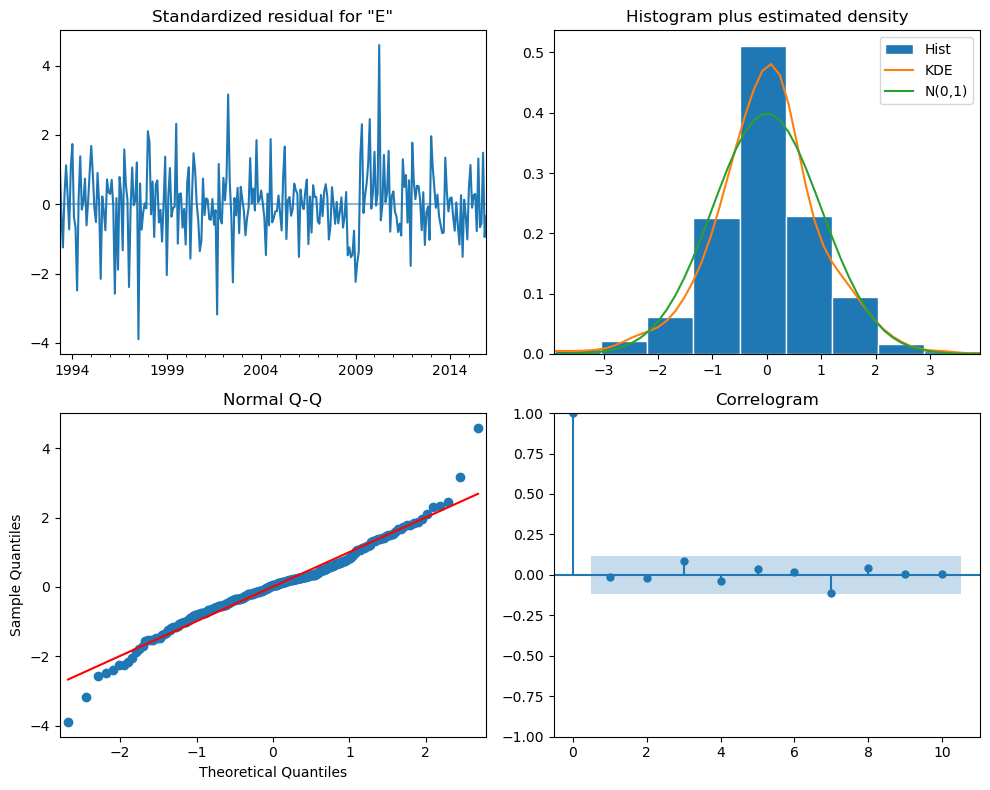

In [21]:
# Diagnostic plots for the model, including residuals and other model checks
model_fit_121.plot_diagnostics(figsize=(10, 8))
plt.tight_layout()
plt.show();

In [22]:
# Extract the residuals (errors) from the fitted model
residuals = model_fit_121.resid  

# Apply the Ljung-Box test on the residuals, on 10 lags.
df_residuals = acorr_ljungbox(residuals, np.arange(1, 11, 1))

# Check if all values in 'lb_pvalue' are lower than 0.05
if (df_residuals['lb_pvalue'] > 0.05).all():
    print('All p-values > 0.05; H0: Residuals are independently distributed and uncorrelated.\n')
else:
    print('There are p-values < 0.05; Ha: Residuals are autocorrelated.\n')

# Show Residuals
df_residuals

There are p-values < 0.05; Ha: Residuals are autocorrelated.



,lb_stat,lb_pvalue
1,48.288697,3.678666e-12
2,49.343352,1.928534e-11
3,49.343408,1.102346e-10
4,49.345698,4.945292e-10
5,49.345899,1.885800e-09
6,49.346573,6.355054e-09
7,49.346595,1.940440e-08
8,49.355182,5.434912e-08
9,49.486581,1.345167e-07
10,49.498899,3.299393e-07


In [23]:
# Dublin-Watson Test
dw_statistic = durbin_watson(residuals)

print(f'Durbin-Watson statistic: {dw_statistic:.4f}')

# Automatic conclusion based on the DW statistic
if dw_statistic < 0.5:
    print("Conclusion: Strong Positive autocorrelation.")
elif 0.5 <= dw_statistic <= 1.5:
    print("Conclusion: Evidence of positive autocorrelation.")
elif 1.5 <= dw_statistic <= 2.5:
    print("Conclusion: No significant autocorrelation.")
elif 2.5 <= dw_statistic <= 3.5:
    print("Conclusion: Evidence of negative autocorrelation.")
elif dw_statistic > 3.5:
    print("Conclusion: Strong negative autocorrelation.")

Durbin-Watson statistic: 2.1429
Conclusion: No significant autocorrelation.


In [24]:
# Forecast the next Time points
forecast_S = model_fit_121.get_forecast(steps=test.shape[0])

# Extract predicted mean and confidence intervals
forecast_mean_S = forecast_S.predicted_mean
conf_int_S = forecast_S.conf_int()        

# Assign forecasts to the test DataFrame
test['Forecast S'] = forecast_mean_S.values                 # Forecast mean

test['Error S'] = test['Forecast S'] - test['Employees']

test['Lower 95% CI S'] = conf_int_S.iloc[:, 0].values       # Lower bound
test['Upper 95% CI S'] = conf_int_S.iloc[:, 1].values       # Upper bound

# Show the updated test DataFrame
test.head()

,Employees,Forecast S,Error S,Lower 95% CI S,Upper 95% CI S
Date,,,,,
2016-01-01,1823.2,1819.876313,-3.323687,1810.183879,1829.568748
2016-02-01,1846.1,1840.809386,-5.290614,1827.034646,1854.584125
2016-03-01,1858.9,1860.405415,1.505415,1842.301682,1878.509149
2016-04-01,1893.9,1884.466273,-9.433727,1861.968173,1906.964373
2016-05-01,1909.8,1908.617298,-1.182702,1881.558639,1935.675958


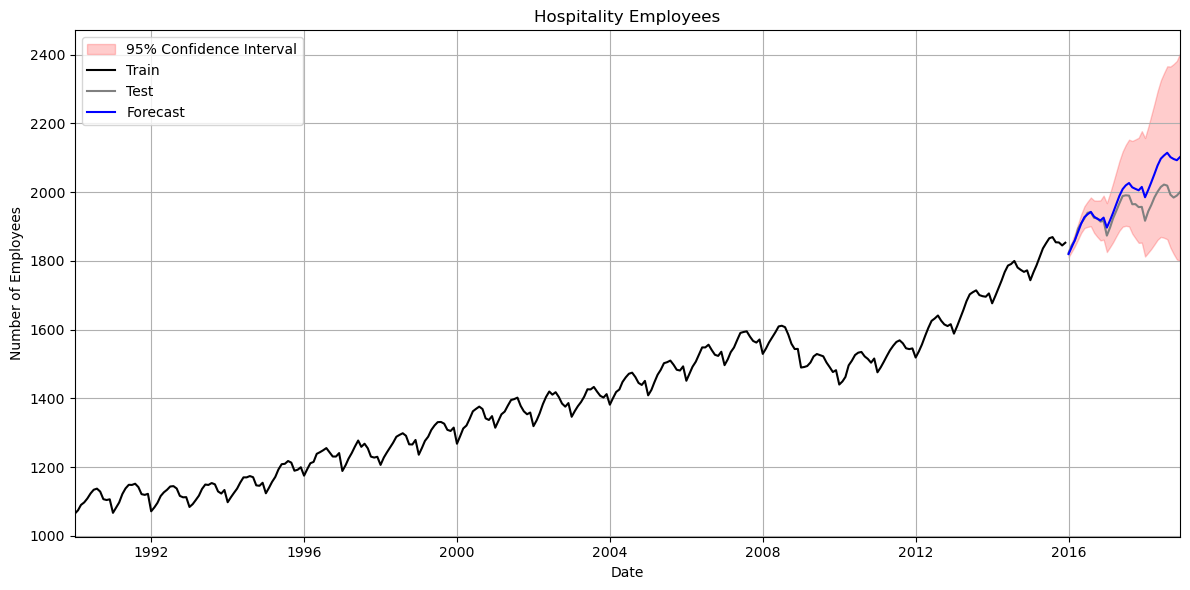

In [25]:
# Plot actual and fitted serie
plt.figure(figsize=(12, 6))                                      

# Plot 95% confidence interval
plt.fill_between(test.index,
                 conf_int_S.iloc[:, 0],     # Lower bound
                 conf_int_S.iloc[:, 1],     # Upper bound
                 color='red', alpha=0.2, label='95% Confidence Interval')

plt.plot(train.index, train['Employees'], label='Train', color='black')      # Train
plt.plot(test.index, test['Employees'], label='Test', color='gray')          # Test
plt.plot(test.index, test['Forecast S'], label='Forecast', color='blue')     # Forecast

plt.title('Hospitality Employees')                      
plt.xlabel('Date')                                        
plt.ylabel('Number of Employees')  
plt.xlim(pd.to_datetime('1990-01-01'), pd.to_datetime('2018-12-01'))
#plt.ticklabel_format(style='plain', axis='y')  # Disable scientific notation on y-axis
plt.grid(True)                                            
plt.legend(loc=2)                                             
plt.tight_layout()                                       
plt.show()

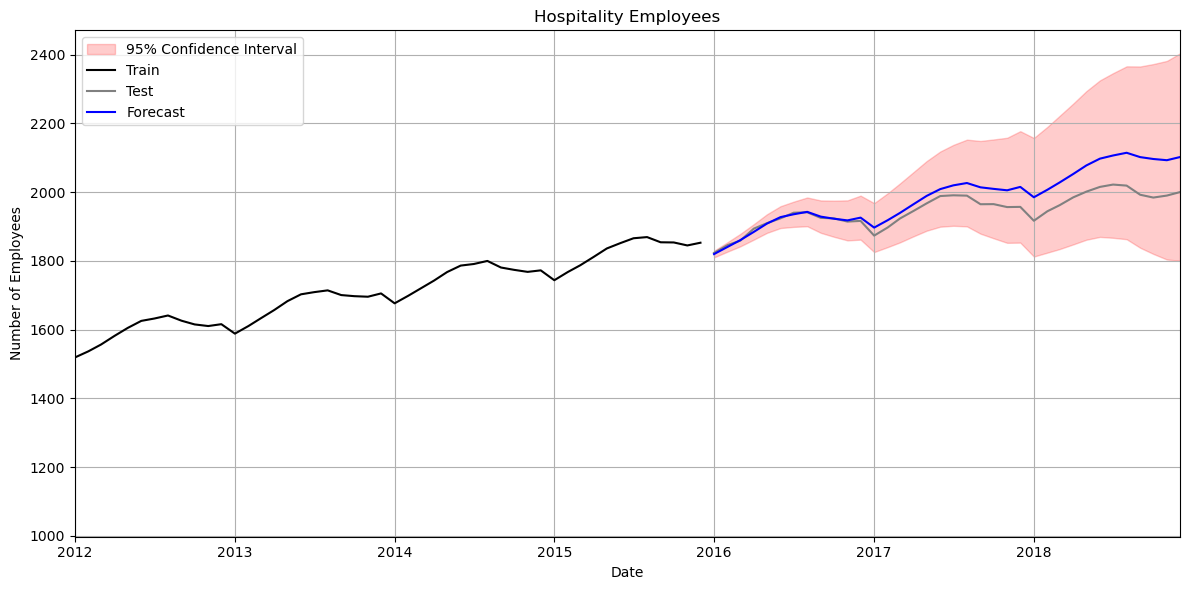

In [26]:
# Plot actual and fitted serie
plt.figure(figsize=(12, 6))                                      

# Plot 95% confidence interval
plt.fill_between(test.index,
                 conf_int_S.iloc[:, 0],     # Lower bound
                 conf_int_S.iloc[:, 1],     # Upper bound
                 color='red', alpha=0.2, label='95% Confidence Interval')

plt.plot(train.index, train['Employees'], label='Train', color='black')      # Train
plt.plot(test.index, test['Employees'], label='Test', color='gray')          # Test
plt.plot(test.index, test['Forecast S'], label='Forecast', color='blue')     # Forecast

plt.title('Hospitality Employees')                      
plt.xlabel('Date')                                        
plt.ylabel('Number of Employees')  
plt.xlim(pd.to_datetime('2012-01-01'), pd.to_datetime('2018-12-01'))
#plt.ticklabel_format(style='plain', axis='y')  # Disable scientific notation on y-axis
plt.grid(True)                                            
plt.legend(loc=2)                                             
plt.tight_layout()                                       
plt.show()

In [27]:
# Calculate MAPE
mape = (np.abs(test['Error S']) / test['Employees']).mean() * 100
accuracy = 100 - mape

# Print the result
print(f"Model Accuracy (based on MAPE): {accuracy:.2f}%")

Model Accuracy (based on MAPE): 97.94%
